In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
from scipy.stats import pearsonr,spearmanr
from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn import fitness
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [3]:
feature = pd.read_pickle('/home/wangs/data/check/all_status.pk').loc['20200104':'20230101']
fields = list(feature.columns)
feature = feature.rank()/feature.count()
feature['test_date'] = feature.index
test_date = feature.index

In [4]:
function_set = ['add','sub','mul','div','sqrt','log','inv','abs','neg']

In [5]:
close_ = ff.read('close').loc[:,'20210104':'20230101']
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
event = ff.read('Gpalpha014').loc[:,'20210104':'20230101']

In [6]:
import statsmodels.api as sm
def open_day_matrix(y,y_pred,w=None):
    best_rate = []
    if len(np.unique(y_pred))<=2:
        return 0
    else:
        data=pd.DataFrame({'y_pred':y_pred,'date':test_date})
        ts = pd.Series(data.loc[:,'y_pred'].values,index = data['date'])
        # for day_len in [5,10,20,50,100]:
        #     open_day = ((ts > ts.rolling(day_len,closed = 'left').quantile(2/3)).loc['20210104':'20230101']).replace({True:1.0,False:0})
        #     ret_all = []
        #     for day in event.columns:
        #         buy_stock =  (event*ff.filter1.loc[:,'20210104':'20230101'])[day].dropna().sort_values().head(20).index
        #         ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
        #     ret_all[-1] = 0.0
        #     best_rate.append(ff.cal_returns(ret_all * open_day.loc['20210104':'20230101'])['收益回撤比'])
        # return np.max(best_rate)
        # open_day = ((ts < ts.rolling(5,closed = 'left').quantile(1/3)).loc['20210104':'20230101']).replace({True:1.0,False:0})
        open_day = ((ts < ts.quantile(2/3)).loc['20210104':'20230101']).replace({True:1.0,False:0})
        if (open_day.sum() == 0):
            return 0
        ret_all = []
        for day in event.columns:
            buy_stock =  (event*ff.filter1.loc[:,'20210104':'20230101'])[day].dropna().sort_values().head(20).index
            ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
        ret_all[-1] = 0.0
        return ff.cal_returns(ret_all * open_day)['收益回撤比']

In [7]:
open_day_fc=make_fitness(function=open_day_matrix,greater_is_better=True)

In [8]:
test_gp=SymbolicTransformer(feature_names = fields,
                            function_set = function_set, #所有算子
                            generations = 4, #进化代数
                            population_size = 500, #种群规模
                            tournament_size = 10, #竞标赛规模
                            p_crossover=0.4,
                            p_subtree_mutation=0.05,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.03,
                            p_point_replace=0.35,
                            init_depth=(1,4),
                            const_range = None,
                            metric=open_day_fc,
                            parsimony_coefficient = 'auto',
                            low_memory=True,
                            verbose=2,
                            n_jobs = 6,
                           stopping_criteria=30.0)

In [9]:
test_gp.fit(np.nan_to_num(feature.loc[:,fields].values),pd.Series(0,feature.index).values)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 22.5min remaining: 45.0min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 22.9min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   0     4.68           1.5378        3          5.18917              N/A     68.69m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 22.4min remaining: 44.8min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 23.3min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   1     4.64          2.53328        8          5.24127              N/A     46.69m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 26.9min remaining: 53.9min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 27.6min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   2     4.73          3.30301        5           5.6378              N/A     27.61m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 22.3min remaining: 44.6min


   3     4.60          4.05149        9          6.00068              N/A      0.00s


[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 22.9min finished


SymbolicTransformer(const_range=None,
                    feature_names=['PB', 'PE', 'std_type_raw', 'ILQ_type_raw',
                                   'std_type', 'ILQ_type', 'high5_rate',
                                   'high20_rate', 'high60_rate', 'high240_rate',
                                   'low5_rate', 'low20_rate', 'low60_rate',
                                   'low240_rate', 'amount_vol', 'circ_mv_vol',
                                   'turnover_rate_vol', 'turnover_rate_f_vol',
                                   'percentile60_mean', 'percentile60_median',
                                   'percentile60_ske...
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'abs', 'neg'],
                    generations=4, init_depth=(1, 4), low_memory=True,
                    metric=<gplearn.fitness._Fitness object at 0x7f8fbc163760>,
                    n_jobs=6, p_crossover=0.4, p_point_mutation=0.03,
                    p_point_replace=0.35, p_subtree_mutation=0.05,
                    parsimony_coefficient='auto', population_size=500,
                    stopping_criteria=30.0, tournament_size=10, verbose=2)

In [10]:
feature_2 = pd.read_pickle('/home/wangs/data/check/all_status.pk').loc['20200104':'20230101']
fields = list(feature_2.columns)
feature_2 = feature_2.rank()/feature_2.count()

2/3开仓比例
Program 1: sub(mul(profit_20, high5_rate), sqrt(sqrt(div(amount5, low60_rate))))
Program 2: sub(div(profit_120, percentile120_median), sqrt(div(amount5, low60_rate)))
Program 3: sub(log(div(profit_120, percentile120_median)), sqrt(div(amount5, low60_rate)))
Program 4: add(turnover_rate_f_vol, div(profit_120, percentile120_median))
Program 5: sub(mul(profit_20, high5_rate), sqrt(div(amount5, low60_rate)))
Program 6: sub(mul(profit_20, high5_rate), sqrt(div(amount5, low60_rate)))
Program 7: div(sqrt(percentile240_mean), percentile60_median)
Program 8: log(div(profit_120, percentile120_median))
Program 9: abs(div(profit_120, percentile120_median))
Program 10: abs(div(profit_120, percentile120_median))


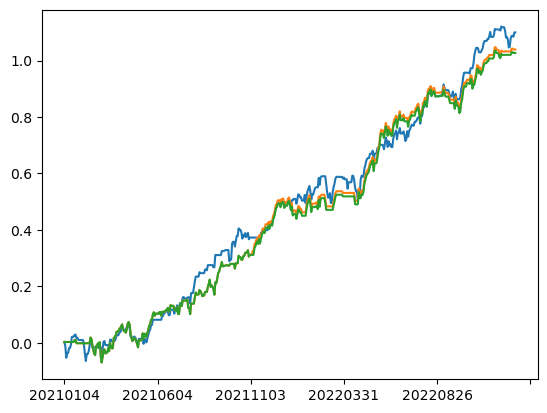

In [22]:
print('2/3开仓比例')
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    transform_X = program.execute(np.nan_to_num(feature_2.loc[:,fields].values))
    ts = pd.Series(transform_X,ff.read('Gpalpha014').loc[:,'20200104':'20230101'].columns)
    open_day = ((ts < ts.quantile(2/3)).loc['20210104':'20230101']).replace({True:1.0,False:0})
    ret_all = []
    for day in event.columns:
        buy_stock =  (event*ff.filter1.loc[:,'20210104':'20230101'])[day].dropna().sort_values().head(20).index
        ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
    ret_all[-1] = 0.0
    if i < 3:
        (ret_all * open_day.loc['20210104':'20230101']).cumsum().plot()

In [24]:
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program},{program,program.fitness_}')

Program 1: sub(mul(profit_20, high5_rate), sqrt(sqrt(div(amount5, low60_rate)))),(<gplearn._program._Program object at 0x7f8f940badc0>, 6.486634988279299)
Program 2: sub(div(profit_120, percentile120_median), sqrt(div(amount5, low60_rate))),(<gplearn._program._Program object at 0x7f8fb2631f70>, 6.408631337264479)
Program 3: sub(log(div(profit_120, percentile120_median)), sqrt(div(amount5, low60_rate))),(<gplearn._program._Program object at 0x7f8f8c26f700>, 6.3919904437447945)
Program 4: add(turnover_rate_f_vol, div(profit_120, percentile120_median)),(<gplearn._program._Program object at 0x7f8f94042460>, 5.907776011210698)
Program 5: sub(mul(profit_20, high5_rate), sqrt(div(amount5, low60_rate))),(<gplearn._program._Program object at 0x7f8f9404a700>, 5.6732307133168565)
Program 6: sub(mul(profit_20, high5_rate), sqrt(div(amount5, low60_rate))),(<gplearn._program._Program object at 0x7f8f940ba2b0>, 5.6732307133168565)
Program 7: div(sqrt(percentile240_mean), percentile60_median),(<gplear

In [12]:
feature.loc[:,fields]

,PB,PE,std_type_raw,ILQ_type_raw,std_type,ILQ_type,high5_rate,high20_rate,high60_rate,high240_rate,...,amount_mean,up_rate,down_rate,continue_up,profit_5,profit_20,profit_120,profit_240,win_ratio,winloss_prop
20200106,0.192837,0.398072,0.140496,0.763774,0.365014,0.763774,0.931129,0.987603,0.980716,0.903581,...,0.045455,0.842975,0.249311,0.844353,0.891185,0.982094,0.920110,0.757576,0.632231,0.929752
20200107,0.249311,0.433884,0.140496,0.763774,0.365014,0.763774,0.975207,0.993113,0.988981,0.936639,...,0.020661,0.882920,0.162534,0.847796,0.957300,0.988981,0.938017,0.798898,0.910468,0.844353
20200108,0.172176,0.395317,0.140496,0.763774,0.365014,0.763774,0.404959,0.757576,0.893939,0.801653,...,0.005510,0.599174,0.247934,0.497245,0.344353,0.949036,0.914601,0.747934,0.082645,0.392562
20200109,0.241047,0.451791,0.504821,0.763774,0.365014,0.763774,0.775482,0.960055,0.973829,0.915978,...,0.099174,0.746556,0.037190,0.184573,0.787879,0.986226,0.935262,0.789256,0.954545,0.359504
20200110,0.228650,0.454545,0.504821,0.763774,0.365014,0.763774,0.586777,0.853994,0.899449,0.851240,...,0.148760,0.285124,0.486226,0.117080,0.570248,0.980716,0.931129,0.775482,0.308540,0.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221226,0.184573,0.067493,0.140496,0.763774,0.365014,0.763774,0.323691,0.037190,0.045455,0.034435,...,0.333333,0.487603,0.250689,0.179752,0.630854,0.048209,0.203857,0.134986,0.869146,0.922865
20221227,0.185950,0.086777,0.140496,0.763774,0.365014,0.763774,0.677686,0.079890,0.108815,0.019284,...,0.265840,0.213499,0.493113,0.581956,0.844353,0.088154,0.235537,0.147383,0.692837,0.426997
20221228,0.152893,0.059229,0.140496,0.763774,0.365014,0.763774,0.272727,0.070248,0.150138,0.049587,...,0.179063,0.085399,0.329201,0.437328,0.447658,0.068871,0.169421,0.123967,0.089532,0.278237
20221229,0.137741,0.060606,0.140496,0.763774,0.365014,0.763774,0.246556,0.052342,0.078512,0.060606,...,0.185950,0.119835,0.371901,0.853306,0.261708,0.071625,0.148760,0.103306,0.258953,0.533058


In [13]:
feature = pd.read_pickle('/home/wangs/data/check/all_status.pk')
data = feature['PB'].rank()/feature['PB'].sum() + feature['PE'].rank()/feature['PE'].sum()

In [14]:
data.loc['20200101':'20210301'] > data.loc['20200101':'20210101'].quantile(0.3)

20200102    False
20200103    False
20200106     True
20200107     True
20200108    False
            ...  
20210223     True
20210224     True
20210225     True
20210226     True
20210301     True
Length: 279, dtype: bool

In [15]:
data.loc['20200101':'20210101'].quantile(0.7)

0.19160701776636

<Axes: >

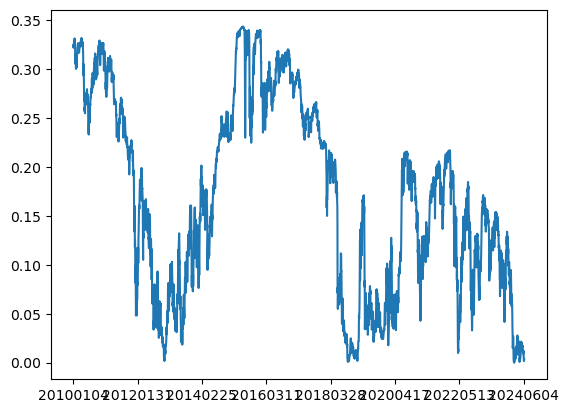

In [16]:
data.plot()

In [17]:
((data > data.rolling(5,closed = 'left').quantile(2/3)).loc['20210104':'20240101']).replace({True:1.0,False:0})

20210104    1.0
20210105    1.0
20210106    0.0
20210107    0.0
20210108    0.0
           ... 
20231225    0.0
20231226    0.0
20231227    0.0
20231228    1.0
20231229    1.0
Length: 727, dtype: float64

In [18]:
rolling_day = [5,10,20,50,100]

In [19]:
test_day_index = data.loc['20210104':'20240101'].index

In [20]:
data > data.rolling(30).quantile(0.7)

20100104    False
20100105    False
20100106    False
20100107    False
20100108    False
            ...  
20240604    False
20240605    False
20240606    False
20240607    False
20240611    False
Length: 3505, dtype: bool

In [21]:
feature['ILQ_type_raw'].quantile(1/5)

0.0